<a href="https://colab.research.google.com/github/christian-eismann/wt21-the-noise-enricher/blob/develop/python_app/nn_vae_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn.functional as F
import torch.optim as optim

import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

spectrograms_path = '/content/drive/MyDrive/sound_classifier/dataset.zip'

!cp '{spectrograms_path}' .
!unzip -q dataset.zip

Mounted at /content/drive


In [3]:

class GTZAN_Dataset(Dataset):
    def __init__(self, dataset, dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(dataset, dtype={'file':str, 'category':int})
        self.dir = dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        filepath = os.path.join(self.dir, self.labels.iloc[idx,0])
        spec = torch.load(filepath)
        label = self.labels.iloc[idx,1]
        
        if self.transform:
            spec = self.transform(spec)
        if self.target_transform:
            label = self.target_transform(label)
        
        return spec, label

In [4]:
root_path = ''
gtzan_trn = GTZAN_Dataset('dataset_files_train.csv', root_path)
gtzan_tst = GTZAN_Dataset('dataset_files_test.csv', root_path)
trn_dataloader = DataLoader(gtzan_trn, batch_size=64, shuffle=True)
tst_dataloader = DataLoader(gtzan_tst, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(trn_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 258, 258])
Labels batch shape: torch.Size([64])


In [209]:
input_dim = 258*258
e_hidden = 2048        # Number of hidden units in the encoder. See AEVB paper page 7, section "Marginal Likelihood"
d_hidden = 2048        # Number of hidden units in the decoder. See AEVB paper page 7, section "Marginal Likelihood"
latent_dim = 2         # Dimension of latent space. See AEVB paper, page 7, section "Marginal Likelihood"
learning_rate = 0.001  # For optimizer (SGD or Adam)
weight_decay = 1e-5    # For optimizer (SGD or Adam)
epochs = 50            # Number of sweeps through the whole dataset

In [210]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoding Layers
        self.e_input2hidden  = nn.Linear(in_features=input_dim, out_features=e_hidden)
        self.e_hidden2mean   = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        self.e_hidden2logvar = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        # Decoding Layers
        self.d_latent2hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
        self.d_hidden2image  = nn.Linear(in_features=d_hidden, out_features=input_dim)
        
    def forward(self, x):
        # Shape Flatten image to [batch_size, input_features]
        x = x.view(-1, input_dim)
        
        # Feed x into Encoder to obtain mean and logvar
        x = torch.tanh(self.e_input2hidden(x))
        mu, logvar = self.e_hidden2mean(x), self.e_hidden2logvar(x)
        
        # Sample z from latent space using mu and logvar
        if self.training:
            z = torch.randn_like(mu).mul(torch.exp(0.5*logvar)).add_(mu)
        else:
            z = mu
        
        # Feed z into Decoder to obtain reconstructed image. Use Sigmoid as output activation (=probabilities)
        x_recon = torch.tanh(self.d_hidden2image(torch.tanh(self.d_latent2hidden(z))))
        
        return x_recon, mu, logvar

In [211]:
# Loss
def vae_loss(image, reconstruction, mu, logvar):
  """Loss for the Variational AutoEncoder."""
  # Binary Cross Entropy for batch
  BCE = F.mse_loss(input=reconstruction, target=image, reduction='mean')
  # Closed-form KL Divergence
  KLD = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE - KLD


In [212]:
vae = VAE()
vae = vae.to(device)
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
vae.train()

VAE(
  (e_input2hidden): Linear(in_features=66564, out_features=2048, bias=True)
  (e_hidden2mean): Linear(in_features=2048, out_features=2, bias=True)
  (e_hidden2logvar): Linear(in_features=2048, out_features=2, bias=True)
  (d_latent2hidden): Linear(in_features=2, out_features=2048, bias=True)
  (d_hidden2image): Linear(in_features=2048, out_features=66564, bias=True)
)

In [213]:
# Train
losses = []

for epoch in range(epochs):
  # Store training losses & instantiate batch counter
  losses.append(0)
  number_of_batches = 0

  # Grab the batch, we are only interested in images not on their labels
  for images, _ in trn_dataloader:
    # Save batch to GPU, remove existing gradients from previous iterations
    images = images.real.to(device)
    optimizer.zero_grad()

    # Feed images to VAE. Compute Loss.
    reconstructions, latent_mu, latent_logvar = vae(images)
    loss = vae_loss(images.view(-1, input_dim), reconstructions.view(-1, input_dim), latent_mu, latent_logvar)

    # Backpropagate the loss & perform optimization step with such gradients
    loss.backward()
    optimizer.step()

    # Add loss to the cumulative sum
    losses[-1] += loss.item()  
    number_of_batches += 1
  
  # Update average loss & Log information
  losses[-1] /= number_of_batches
  print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, epochs, losses[-1]))    

Epoch [1 / 50] average reconstruction error: 17691.975600
Epoch [2 / 50] average reconstruction error: 45.648212
Epoch [3 / 50] average reconstruction error: 35.165435
Epoch [4 / 50] average reconstruction error: 28.007173
Epoch [5 / 50] average reconstruction error: 22.858257
Epoch [6 / 50] average reconstruction error: 19.053126
Epoch [7 / 50] average reconstruction error: 16.142295
Epoch [8 / 50] average reconstruction error: 13.874711
Epoch [9 / 50] average reconstruction error: 12.066907
Epoch [10 / 50] average reconstruction error: 10.598632
Epoch [11 / 50] average reconstruction error: 9.392463
Epoch [12 / 50] average reconstruction error: 8.389631
Epoch [13 / 50] average reconstruction error: 7.548355
Epoch [14 / 50] average reconstruction error: 6.840820
Epoch [15 / 50] average reconstruction error: 6.243190
Epoch [16 / 50] average reconstruction error: 5.737594
Epoch [17 / 50] average reconstruction error: 5.306082
Epoch [18 / 50] average reconstruction error: 4.939044
Epoch 

In [214]:
trans_spec_inv = torchaudio.transforms.InverseSpectrogram(n_fft=515)

In [215]:
# transforming spectrogram to fit in model

test_spec = torch.load('spectrograms/blues/blues_0_0.pt')

test_spec_r = test_spec.real
test_spec_i = test_spec.imag

test_spec_ = torch.reshape(test_spec_r, (1, input_dim))

# load into model and backtransform dimension
recon_spec = vae(test_spec_.to(device))[0]
recon_spec = torch.reshape(recon_spec, (1, 258, 258))

recon_complex = torch.complex(recon_spec.to('cpu'), test_spec_i.to('cpu'))
out = trans_spec_inv(recon_complex.to('cpu'))
torchaudio.save(filepath='result.wav', src=out, sample_rate=22050)

print(recon_spec.min(), recon_spec.max())
print(test_spec_i.max(), test_spec_i.min())


tensor(-0.2849, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.2832, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(45.6951) tensor(-56.8613)


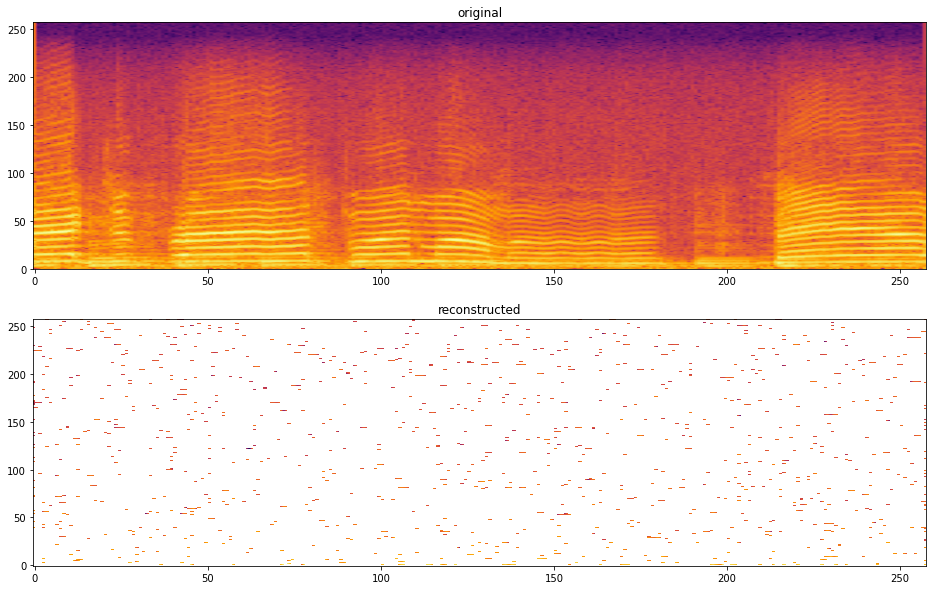

In [216]:
import matplotlib.pyplot as plt

original = test_spec.log2().real[0,:,:].numpy()
reconstr = recon_spec.log2()[0,:,:].cpu().detach().numpy()

fig, ax = plt.subplots(2,1, figsize=(16, 10))

ax[0].imshow(original, aspect='auto', origin='lower', cmap='inferno')
ax[1].imshow(reconstr, aspect='auto', origin='lower', cmap='inferno')

ax[0].set_title('original')
ax[1].set_title('reconstructed')

plt.show()